In [360]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [9]:
# this block is used for copying/moving files
import os
import shutil
import time
#shutil.copyfile('src', 'dst')
#shutil.move

# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/bin/python'

In [10]:
# This is a custom python module with dictionaries of states and countries; 
# it also contains three functions repair_dict, reverse_dict, and custom_list
import state_country_dicts as scd

In [11]:
# provides ability to reload modules (wihtout leaving jupyter) if changes are made
#import importlib
#importlib.reload(scd)

In [12]:
import numpy as np
import pandas as pd

In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Cornavirus section

In [14]:
# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2022-01-13'

In [15]:
print ('If using Binder enter a timezone difference from UTC')
timezone = input(' Enter a number between 12 and -12:')
print(timezone)
if timezone:
    timezone = int(timezone)
    v = scd.tz_dict[timezone]
    t = pd.Timestamp.today(v)
    print (t)
    day = t.date().strftime('%Y-%m-%d')
day

If using Binder enter a timezone difference from UTC


 Enter a number between 12 and -12: 


'2022-01-13'

### Moves all files from covid_data_update to covid_data 

In [298]:
# Ensure helper files used in past have been removed
!rm -f covid_data/covid_text covid_data/flist_of_covid_png covid_data/temp.xlsx
!rm -f covid_text flist_of_covid_png temp.xlsx

In [299]:
!mkdir covid_data_update

mkdir: covid_data_update: File exists


In [300]:
# House keeping covid_data_update folder
# preparing the move of all files from covid_data_update to covid_data 
# so that we are left with an empty covid_date_update folder
file_names = []
source_dir = 'covid_data_update'
target_dir = 'covid_data'
print("covid_data_update directory contents:") 
file_names = os.listdir(source_dir)
print (file_names)
if file_names == []:
    print ('Directory is empty so no files available to move')

covid_data_update directory contents:
['us_AR_CO_IL_NY_TX_last_60_days_2022-01-13.png', 'us_AR_CO_IL_NY_TX_last_90_days_2022-01-13.png', 'us_2022-01-13.png', 'world_DE_ES_FR_UK_IT_US_last_90_days_2022-01-13.png', 'world_rolling_avg_2022-01-13.png', 'world_DE_ES_FR_UK_IT_US_last_60_days_2022-01-13.png', 'us_rolling_avg_2022-01-13.png', 'world_2022-01-13.png']


In [301]:
# The below cell will move and archive all files in covid_data_update to covid_data

In [302]:
%%capture
# Move contents of source ('covid_data_update')to target ('covid_data')
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [303]:
def clean_up (number_str):
    '''This is a clean up routine so that only numeric characters remain'''
    number_str = number_str.replace(',', '').replace('null','0').rstrip(']').lstrip("'")
    return int(number_str)

### Custom state dictionaries

In [304]:
# creates a custom state dict
s_string = input('Enter state codes seperated by a space:') or 'ca ny il'
print()

slist = scd.custom_list (s_string)
state_dict = {key: value for key, value in scd.all_states.items() if value in slist}
state_dict

Enter state codes seperated by a space: co ar il


{'arkansas': 'AR', 'colorado': 'CO', 'illinois': 'IL'}

### Add state and world population data

In [305]:
all_state_pop = pd.read_csv('state_pop.csv').iloc[:,1:3].set_index('Code')
all_state_pop.head()

,pop_millions
Code,
AL,5.024279
AK,0.733391
AZ,7.151502
AR,3.011524
CA,39.538223


In [306]:
world_pop = pd.read_csv('world_pop.csv').iloc[:,0:2].set_index('country')
world_pop['pop_millions'] = world_pop.population/1000000
world_pop.head()

,population,pop_millions
country,,
China,1440297825,1440.297825
India,1382345085,1382.345085
United States,331341050,331.341050
Indonesia,274021604,274.021604
Pakistan,221612785,221.612785


### State Scraping section

In [307]:
# The start dates for U.S.states and for countries are different so must be accounted for
st_start = pd.Timestamp('2020/3/13')
c_start = pd.Timestamp('2020/2/16')

# set end date to yesterday

#day == pd.Timestamp.today().strftime('%Y-%m-%d')
end = pd.Timestamp.today() - pd.Timedelta(days=1)
print(f'End date is set to yesterday: {end}')
    
# set the index to the appropriate date range for states and countries
st_index = pd.date_range(st_start, end)
c_index = pd.date_range(c_start, end)
len(st_index)
len(c_index)

# list comprehension to extract just the state initials from the dict
st_list = list(state_dict.values())

# create an empty pandas df with column headers from state_dict
state = pd.DataFrame(columns = st_list,index=st_index)
state.sort_index(ascending = False).head()
state.shape

End date is set to yesterday: 2022-01-12 14:01:45.980274


671

697

,AR,CO,IL
2022-01-12,NaN,NaN,NaN
2022-01-11,NaN,NaN,NaN
2022-01-10,NaN,NaN,NaN
2022-01-09,NaN,NaN,NaN
2022-01-08,NaN,NaN,NaN


(671, 3)

In [308]:
state_url='https://www.worldometers.info/coronavirus/usa/'
# Here the keys are the state names and the values are the 2-letter abbreviation
for key, value in state_dict.items():
    url = state_url+key

    # scrape web page for state info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break
    

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    #state_previous_cases is a list of daily new coronavirus cases
    state_previous_cases = mo.group().split(',')[1:]
    len(state_previous_cases)
    
    # ensure match between length of the empty df and the new list
    if len(st_index)!= len(state_previous_cases):
        print (len(st_index))
        print (len(state_previous_cases))
        state_previous_cases = state_previous_cases[:-1]
        print (len(state_previous_cases))
    
    # merge states into the existing df and apply the function clean_up to convert strings to ints
    # state[value] where value is the 2-letter abreviation
    state[value] = state_previous_cases
    state[value] = state[value].fillna(0).apply(clean_up)
    
    time.sleep(2)
state.sort_index(ascending = False).head()   

671

671

671

,AR,CO,IL
2022-01-12,10974,12547,34573
2022-01-11,7756,22058,28110
2022-01-10,4747,11545,19237
2022-01-09,4308,30802,29585
2022-01-08,8171,8754,29011


In [309]:
# Create df of new_cases/million population
cols = state.columns.to_list()
cols

['AR', 'CO', 'IL']

In [310]:
# Extract just the poopulations for the states of interest
pop_series = all_state_pop.loc[cols].pop_millions
pop_series

Code
AR     3.011524
CO     5.773714
IL    12.801989
Name: pop_millions, dtype: float64

In [311]:
state_cases_by_million = state/pop_series
state_cases_by_million.tail(7)

,AR,CO,IL
2022-01-06,2585.734000,1370.348445,3443.917972
2022-01-07,2800.575390,1727.137853,3351.276118
2022-01-08,2713.244191,1516.181785,2266.132239
2022-01-09,1430.504954,5334.867643,2310.969022
2022-01-10,1576.278323,1999.579473,1502.657126
2022-01-11,2575.440209,3820.417845,2195.752551
2022-01-12,3644.002173,2173.124613,2700.595978


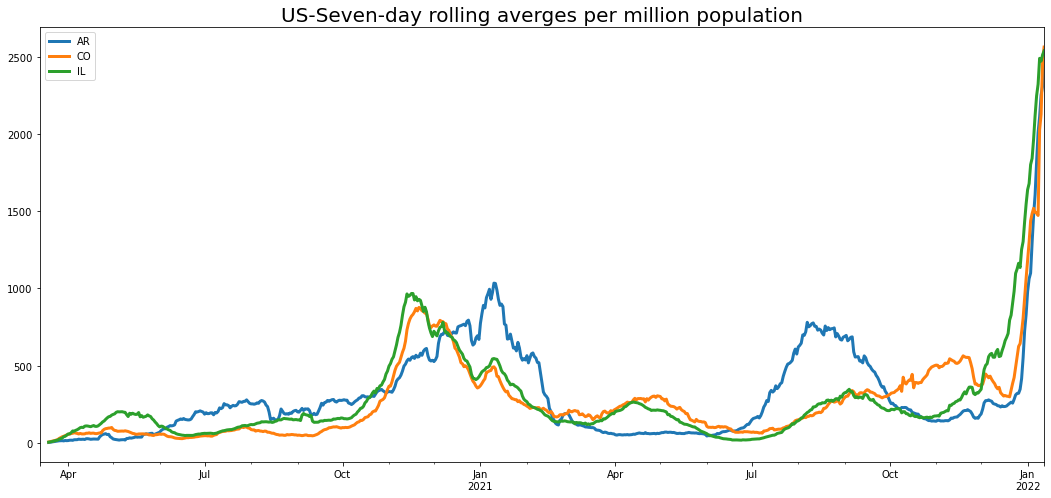

In [312]:
# Plot 7-day moving averge per million population
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = state_cases_by_million.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('US-Seven-day rolling averges per million population',fontsize=20);
#plt.savefig(f'./covid_data_update/us_rolling_avg_per_million_{day}.png');

In [313]:
def list2string(l): 
    ''' This creates a a short string of state/country names 
    used during file save
    '''
    str1 = "_" 
    # return string  
    return (str1.join(l))

States available: ['AR', 'CO', 'IL']



Choose state for rolling averge: 


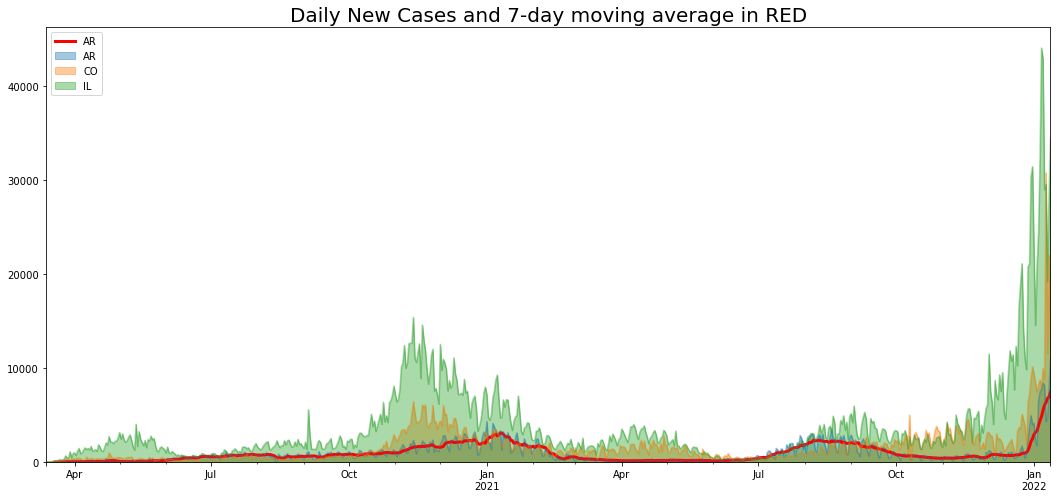

In [314]:
# Allows user to select state for rolling average 
s_available = list(state.columns)
print(f'States available: {s_available}')
print()

snames = (list2string(s_available))

select_state = input('Choose state for rolling averge:')or s_available[0]
select_state = select_state.upper()

if select_state not in s_available:
    select_state = s_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = state.loc[:,[select_state]].rolling(window=7).mean()

roll_data.plot(ax=ax, linewidth=3, color='r')
state.plot(kind='area',alpha=.4,ax=ax,stacked=False);
plt.title('Daily New Cases and 7-day moving average in RED', fontsize=20) 

#ax.set_title('Daily New Cases and 7-day moving average in RED', fontsize=20) 
plt.savefig(f'./covid_data_update/us_{day}.png');

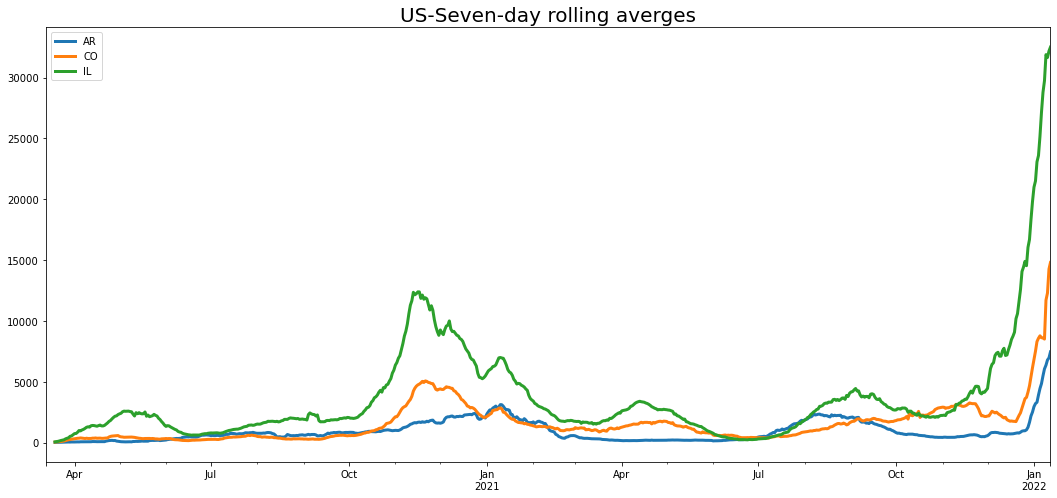

In [315]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = state.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('US-Seven-day rolling averges',fontsize=20)
plt.savefig(f'./covid_data_update/us_rolling_avg_{day}.png');

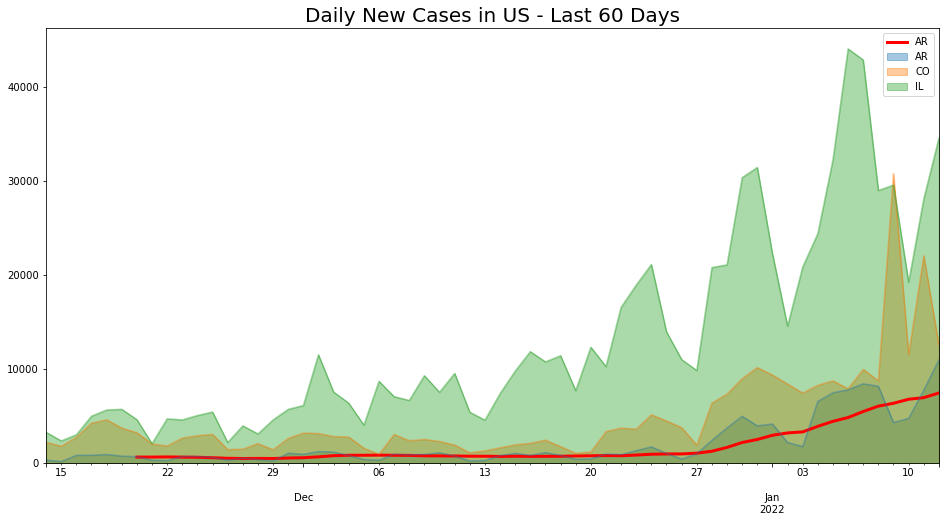

In [316]:
# Plot Last 60 Days
plt.close('all')
# Select last 60 days only
state_last60 = state.tail(60)

roll_data = state_last60.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last60.plot(kind='area',alpha=.4,ax=ax,stacked=False);

plt.title('Daily New Cases in US - Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_60_days_{day}.png');

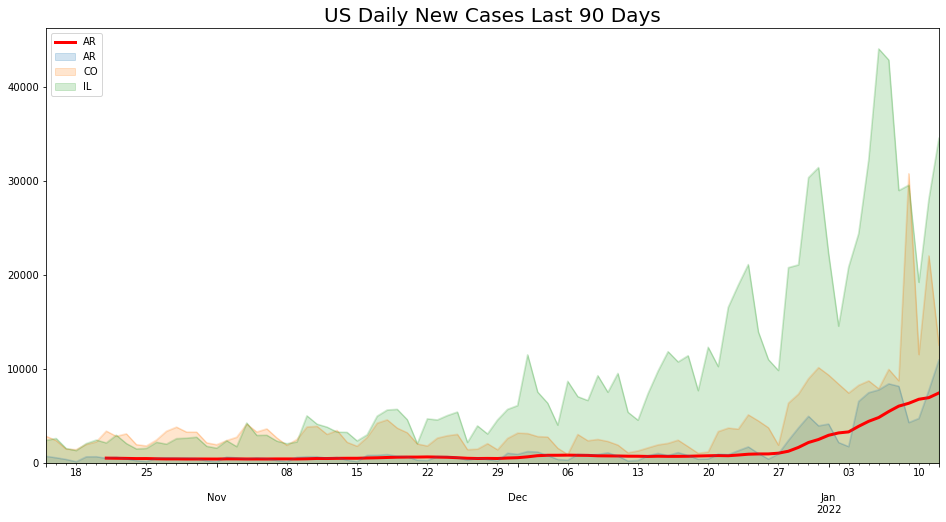

In [317]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
state_last90 = state.tail(90)

roll_data = state_last90.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('US Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_90_days_{day}.png');

In [318]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
state.sort_index(ascending = False)

,AR,CO,IL
2022-01-12,10974,12547,34573
2022-01-11,7756,22058,28110
2022-01-10,4747,11545,19237
2022-01-09,4308,30802,29585
2022-01-08,8171,8754,29011
2022-01-07,8434,9972,42903
2022-01-06,7787,7912,44089
2022-01-05,7488,8748,32279
2022-01-04,6562,8278,24423
2022-01-03,1750,7451,20866


### Custom country dictionaries

In [47]:
#list(scd.all_countries.items())

In [319]:
# creates a custom country dict
c_string = input('Enter country codes seperated by a space:') or 'fr it es'
clist = scd.custom_list (c_string)

country_dict = {key: value for key, value in scd.all_countries.items() if value in clist}
print(country_dict)

print()

Enter country codes seperated by a space: fr it uk es


{'spain': 'ES', 'france': 'FR', 'uk': 'UK', 'italy': 'IT'}



### Scraping section

In [320]:
c_list = list(country_dict.values())
c_list

# create an empty pandas df with column headers from country_dict, using the starting dates for the country as index
country = pd.DataFrame(columns = c_list,index=c_index)
country.sort_index(ascending = False).head()

base_url='https://www.worldometers.info/coronavirus/country/'
# Here the keys are the country names and the values are the 2-letter abbreviation
for key, value in country_dict.items():
    url = base_url+key
    print(url)

    # scrape web page for country info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    #print(response.text[:400])
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    dat = soup.find(text=re_graph)
   
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    country_previous_cases = mo.group().split(',')[1:]
    #print(country_previous_cases)
    previous_cases = ["0" if i == 'null' else i for i in country_previous_cases]
    
    len(previous_cases)

    # merge countries into the existing df and apply the function clean_up to convert strings to ints
    country[value] = previous_cases
    country[value] = country[value].fillna(0).apply(clean_up)
    
    time.sleep(2)
country.clip(lower=0,inplace=True) #large negative number removed for better graphic clarity
country.sort_index(ascending = False).head()

['ES', 'FR', 'UK', 'IT']

,ES,FR,UK,IT
2022-01-12,NaN,NaN,NaN,NaN
2022-01-11,NaN,NaN,NaN,NaN
2022-01-10,NaN,NaN,NaN,NaN
2022-01-09,NaN,NaN,NaN,NaN
2022-01-08,NaN,NaN,NaN,NaN


https://www.worldometers.info/coronavirus/country/spain


697

https://www.worldometers.info/coronavirus/country/france


697

https://www.worldometers.info/coronavirus/country/uk


697

https://www.worldometers.info/coronavirus/country/italy


697

,ES,FR,UK,IT
2022-01-12,179125,361719,128435,196186
2022-01-11,134942,368149,119655,220513
2022-01-10,97464,93896,139212,101749
2022-01-09,97465,296097,139577,155986
2022-01-08,97465,303669,144484,197951


In [321]:
clist

['FR', 'IT', 'UK', 'ES']

In [322]:
# create a reveresed iso3166 country-code dictionary
iso3166r = scd.reverse_dict(scd.iso3166)

In [323]:
country_dict = {key: value for key, value in scd.iso3166r.items() if value in clist}
w_cols = list(country_dict.keys())

# fix uk entries to match conventional country names
if 'uk' in w_cols:
    w_cols.remove('uk')
    w_cols.append('United Kingdom')
if 'US' in w_cols:
    w_cols.remove('US')
    w_cols.append('United States')
w_cols

['Spain', 'France', 'Italy', 'United Kingdom']

In [324]:
# Extract just the populations for the states of interest
wpop_series = world_pop.loc[w_cols].pop_millions
wpop_series

country
Spain             46.757980
France            65.298930
Italy             60.446035
United Kingdom    67.948282
Name: pop_millions, dtype: float64

In [325]:
wpop_series.index

Index(['Spain', 'France', 'Italy', 'United Kingdom'], dtype='object', name='country')

In [326]:
wpop_series.rename(index=iso3166r, inplace=True)

In [327]:
wpop_series

country
ES                46.757980
FR                65.298930
IT                60.446035
United Kingdom    67.948282
Name: pop_millions, dtype: float64

In [328]:
# repair issues with uk and us
wpop_series.rename({'United Kingdom':'UK','United States':'US'},inplace=True)

In [329]:
world_cases_by_million = country/wpop_series
world_cases_by_million.tail()

,ES,FR,IT,UK
2022-01-08,2084.457027,4650.443736,3274.838457,2126.381944
2022-01-09,2084.457027,4534.484715,2580.582829,2054.165255
2022-01-10,2084.435641,1437.940867,1683.303131,2048.793522
2022-01-11,2885.967272,5637.902489,3648.097017,1760.971675
2022-01-12,3830.896886,5539.432269,3245.638858,1890.187599


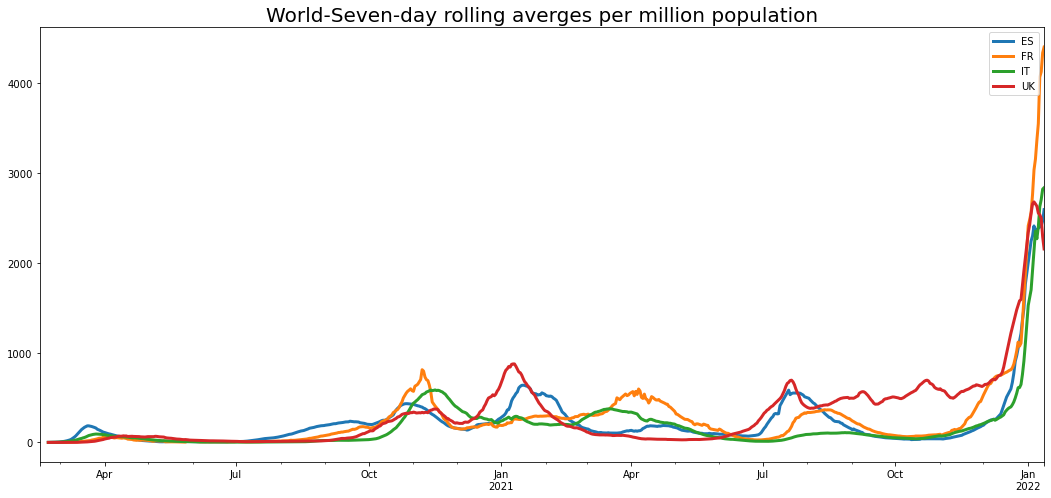

In [330]:
# Plot 7-day moving averge per million population
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = world_cases_by_million.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges per million population',fontsize=20);
#plt.savefig(f'./covid_data_update/us_rolling_avg_per_million_{day}.png');

Countries available: ['ES', 'FR', 'UK', 'IT']



Choose country for rolling averge: 


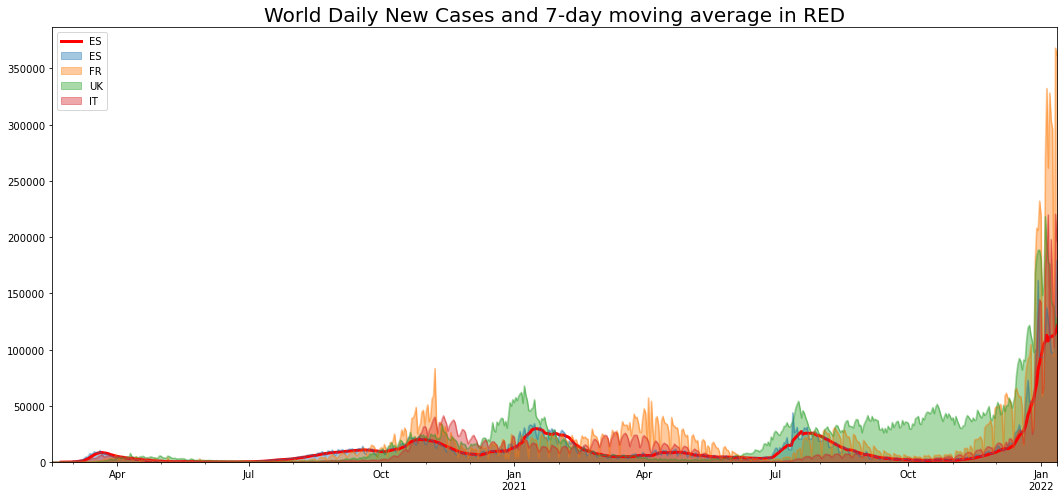

In [331]:
# Allows user to select the country for the rolling average
c_available = list(country.columns)
print(f'Countries available: {c_available}')
print()

snames = (list2string(c_available))

select_country = input('Choose country for rolling averge:') or c_available[0]
select_country = select_country.upper()

if select_country not in c_available:
    select_country = c_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = country.loc[:,[select_country]].rolling(window=7).mean()


roll_data.plot(ax=ax, linewidth=3, color='r')
country.plot(kind='area',alpha=.4,ax=ax,stacked=False)
plt.title('World Daily New Cases and 7-day moving average in RED',fontsize=20);
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_{day}.png');

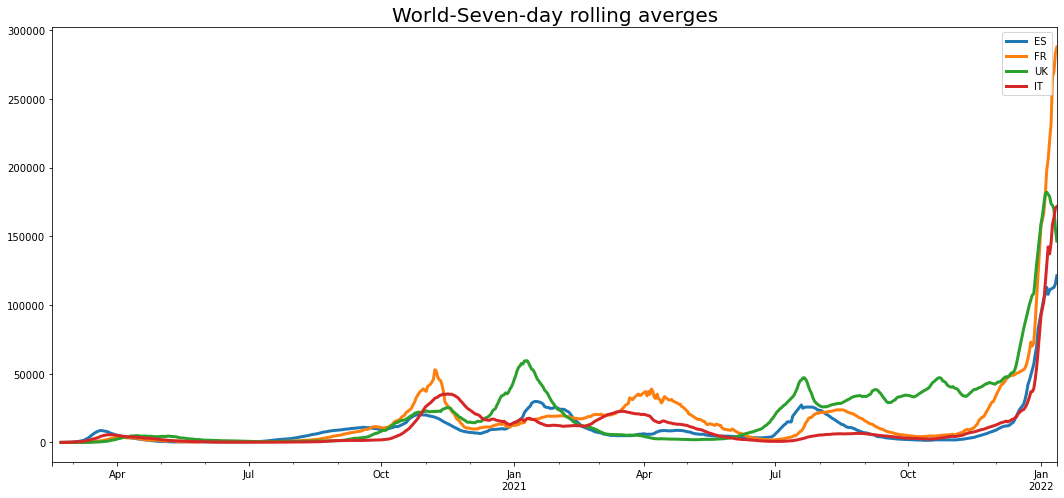

In [332]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = country.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges',fontsize=20)
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_rolling_avg_{day}.png');

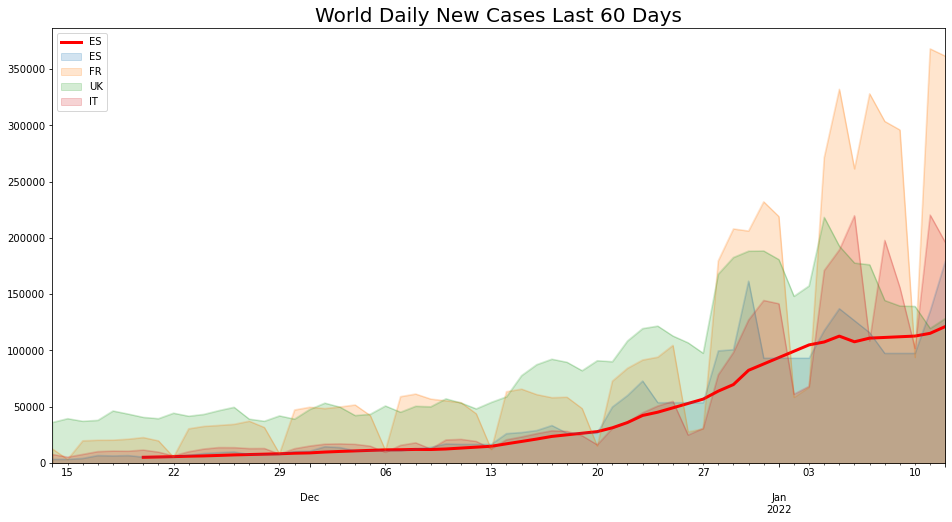

In [333]:
# Plot last 60 days
plt.close('all')
# Select last 60 days only
country_last60 = country.tail(60)

roll_data = country_last60.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last60.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_60_days_{day}.png');


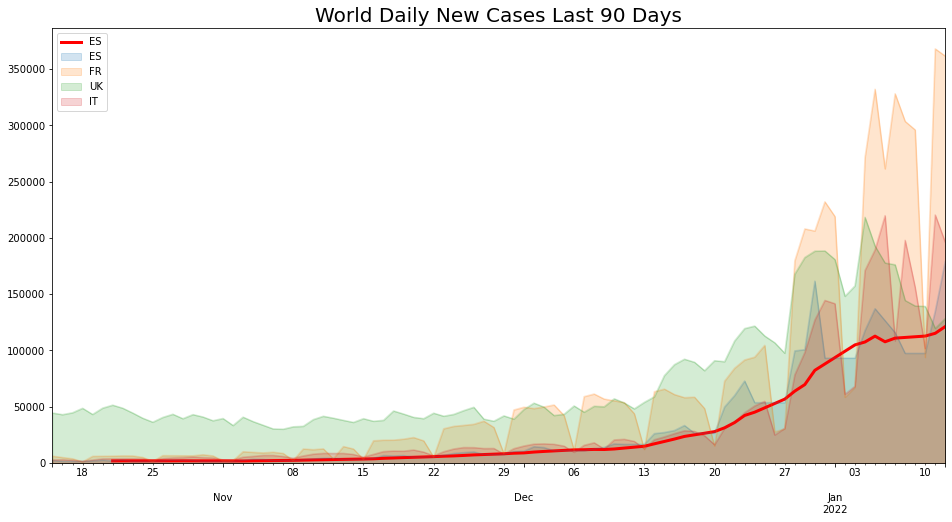

In [334]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
country_last90 = country.tail(90)

roll_data = country_last90.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_90_days_{day}.png');


In [335]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)

In [336]:
# Note that new cases provided for Spain have a pattern of muliple days with exactly the same number
country.sort_index(ascending = False)

,ES,FR,UK,IT
2022-01-12,179125,361719,128435,196186
2022-01-11,134942,368149,119655,220513
2022-01-10,97464,93896,139212,101749
2022-01-09,97465,296097,139577,155986
2022-01-08,97465,303669,144484,197951
2022-01-07,115900,328214,176249,108515
2022-01-06,126540,261481,177762,219897
2022-01-05,137180,332252,192768,189496
2022-01-04,117775,271686,218376,171182
2022-01-03,93190,67461,157432,68188


### Save merged dataframes to csv

In [337]:
# Merge state and country dfs into one
world = state.merge(country,left_index=True,right_index=True,how='outer')
world = world.fillna(0).astype(int)

In [338]:
# Sorting the table with recent dates on the top
world_table = world.sort_index(ascending = False)

# Save to csv by uncommenting out the next line
# world_table.to_csv(f'./covid_data/world_table{day}.csv')
world_table.head(5)

,AR,CO,IL,ES,FR,UK,IT
2022-01-12,10974,12547,34573,179125,361719,128435,196186
2022-01-11,7756,22058,28110,134942,368149,119655,220513
2022-01-10,4747,11545,19237,97464,93896,139212,101749
2022-01-09,4308,30802,29585,97465,296097,139577,155986
2022-01-08,8171,8754,29011,97465,303669,144484,197951


In [361]:
total_by_million = state_cases_by_million.merge(world_cases_by_million,left_index=True, right_index=True, how='outer')
total_by_million.tail()

,AR,CO,IL,ES,FR,IT,UK
2022-01-08,2713.244191,1516.181785,2266.132239,2084.457027,4650.443736,3274.838457,2126.381944
2022-01-09,1430.504954,5334.867643,2310.969022,2084.457027,4534.484715,2580.582829,2054.165255
2022-01-10,1576.278323,1999.579473,1502.657126,2084.435641,1437.940867,1683.303131,2048.793522
2022-01-11,2575.440209,3820.417845,2195.752551,2885.967272,5637.902489,3648.097017,1760.971675
2022-01-12,3644.002173,2173.124613,2700.595978,3830.896886,5539.432269,3245.638858,1890.187599


### Weekly Sums

In [339]:
# Note that the last week may be only a partial unless this is executed at end of week
# End of week is Sunday, so this should be executed on Mondays
df1 = world.resample('w').sum()
df1.sort_index(ascending = False).head(10)

,AR,CO,IL,ES,FR,UK,IT
2022-01-16,23477,46150,81920,411531,823764,387302,518448
2022-01-09,44500,81917,223156,785515,1860860,1206648,1111215
2022-01-02,22409,52547,150465,695349,1134290,1154093,682187
2021-12-26,6765,25242,104225,370309,490219,750598,258697
2021-12-19,5222,12171,63489,185271,367157,541880,163982
2021-12-12,5070,14154,54212,98530,341428,355016,116680
2021-12-05,5769,17531,45915,78576,297216,317050,101472
2021-11-28,3417,15407,29023,55039,205077,301501,82300
2021-11-21,4410,22356,28397,37559,127326,284344,65707
2021-11-14,3515,20876,23866,23771,70161,258905,51828


### Custom graphs section

In [362]:
print ("state (1)\nstate_cases_by_million (2)\ncountry (3)\nworld_cases_by_million (4)\nworld (5)")
print()
choice = input("Select the dataframe of interest from the above: 1 to 6  ")
print (choice)
if choice == '1':
    df = state
    print('**state selected**')
    title ='Custom rolling averges'
elif choice == '2':
    df = state_cases_by_million
    print('**state_cases_by_million selected**')
    title ='Custom rolling averges per million population'
elif choice == '3':
    df = country
    print('**country selected**')
elif choice == '4':
    df = world_cases_by_million
    print('**world_cases_by_million selected**')
    title ='Custom rolling averges per million population'
elif choice == '5':
    df = world
    print('**world selected**')
    title ='Custom rolling averges'
elif choice == '6':
    df = total_by_million
    print('**total_by_million selected**')
    title ='Custom rolling averges'
else:
    print("Not a choice")

state (1)
state_cases_by_million (2)
country (3)
world_cases_by_million (4)
world (5)



Select the dataframe of interest from the above: 1 to 6   6


6
**total_by_million selected**


In [363]:
df.tail()

,AR,CO,IL,ES,FR,IT,UK
2022-01-08,2713.244191,1516.181785,2266.132239,2084.457027,4650.443736,3274.838457,2126.381944
2022-01-09,1430.504954,5334.867643,2310.969022,2084.457027,4534.484715,2580.582829,2054.165255
2022-01-10,1576.278323,1999.579473,1502.657126,2084.435641,1437.940867,1683.303131,2048.793522
2022-01-11,2575.440209,3820.417845,2195.752551,2885.967272,5637.902489,3648.097017,1760.971675
2022-01-12,3644.002173,2173.124613,2700.595978,3830.896886,5539.432269,3245.638858,1890.187599


In [ ]:
import date_select as ds
start,stop = ds.date_maker()

 Select START date


 10/2021


START:	 2021-10-01 00:00:00
STOP:	 2021-10-31 00:00:00


In [353]:
current_cols = df.columns.to_list()
print (current_cols)

['AR', 'CO', 'IL', 'ES', 'FR', 'UK', 'IT']


In [354]:
s_string = input('Enter any codes from the above list:') or current_cols
print()

Enter any codes from the above list: il es


In [355]:
slist = scd.custom_list (s_string)
slist

['IL', 'ES']

In [356]:
new_slist =[]
for item in slist:
    if item in current_cols:
        new_slist.append(item)
new_slist

['IL', 'ES']

In [358]:
df = df.loc[start:stop, new_slist]
df.tail()

,IL,ES
2022-01-08,29011,97465
2022-01-09,29585,97465
2022-01-10,19237,97464
2022-01-11,28110,134942
2022-01-12,34573,179125


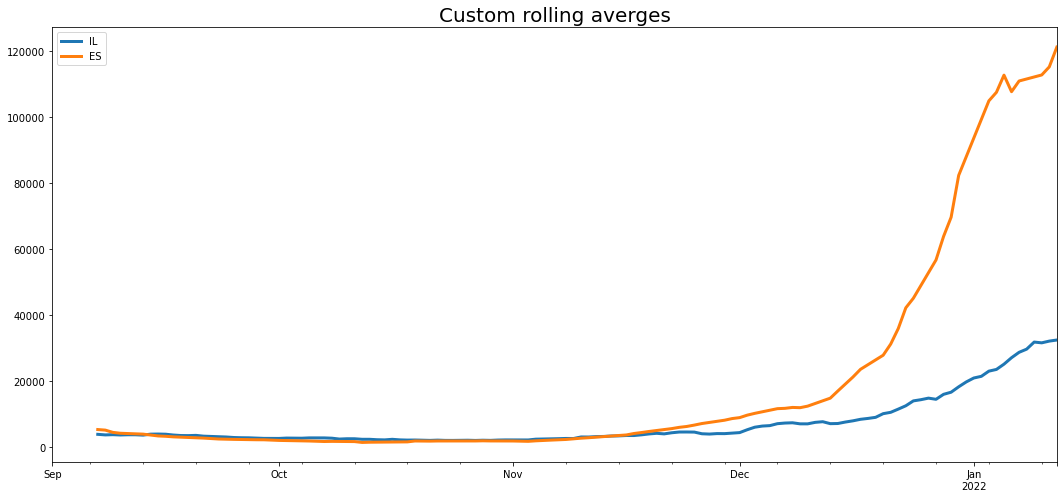

In [359]:
# Plot custom moving averge (default: 7 days) per million population
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = df.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title(title,fontsize=20);
#plt.savefig(f'./covid_data_update/us_rolling_avg_per_million_{day}.png');

### Displays all updated graphs files

In [ ]:
!ls covid_data_update

In [ ]:
'''
commented out this cell - reduncey of displaying plots twice

!ls covid_data_update/*.png > flist_of_covid_png 

# Loop through the file flist and store filenames in png_list
with open('flist_of_covid_png') as f:
    png_str = f.read()
png_list = png_str.split('\n')[0:-1]

png_list

from IPython.display import Image

for file in png_list:    
    local = Image(file)
    local
'''

### tabla rasa

In [ ]:
# this cell will delete all files created in todays session
!rm -rf covid_data_update

In [ ]:
# Ensure helper files used have been removed
!rm -f covid_data/covid_text covid_data/flist_of_covid_png covid_data/temp.xlsx
!rm -f flist_of_covid_png